In [1]:
import wfdb
import pywt
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

In [2]:
def generate_scalogram(signal, filename):
    scales = np.arange(1, 128)
    coef, _ = pywt.cwt(signal, scales, 'morl')
    plt.imshow(coef, cmap='jet', aspect='auto')
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

train_gen = datagen.flow_from_directory(
    './cwt_images',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for 3+ classes
    subset='training'
)

val_gen = datagen.flow_from_directory(
    './cwt_images',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5200 images belonging to 5 classes.
Found 1300 images belonging to 5 classes.


In [4]:
# 1. Load Pretrained ResNet50 (excluding top layer)
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# 2. Freeze base model
base_model.trainable = False

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [5]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(5, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)
model.save('ecg_model_resnet101_epochs-10.h5')

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.3183 - loss: 1.5450 - val_accuracy: 0.3723 - val_loss: 1.5034
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.5190 - loss: 1.4951 - val_accuracy: 0.5562 - val_loss: 1.4601
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.5591 - loss: 1.4496 - val_accuracy: 0.6323 - val_loss: 1.4172
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.6052 - loss: 1.4062 - val_accuracy: 0.5831 - val_loss: 1.3750
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.6076 - loss: 1.3570 - val_accuracy: 0.6492 - val_loss: 1.3307
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.6155 - loss: 1.3291 - val_accuracy: 0.6300 - val_loss: 1.2868
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.6251 - loss: 1.2723 - val_accuracy: 0.6415 - val_loss: 1.2433
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.6281 - loss: 1.2409 - val_accu

In [8]:
loss, accuracy = model.evaluate(val_gen)
print(f"Test Accuracy: {accuracy*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6764 - loss: 1.1239
Test Accuracy: 66.69%


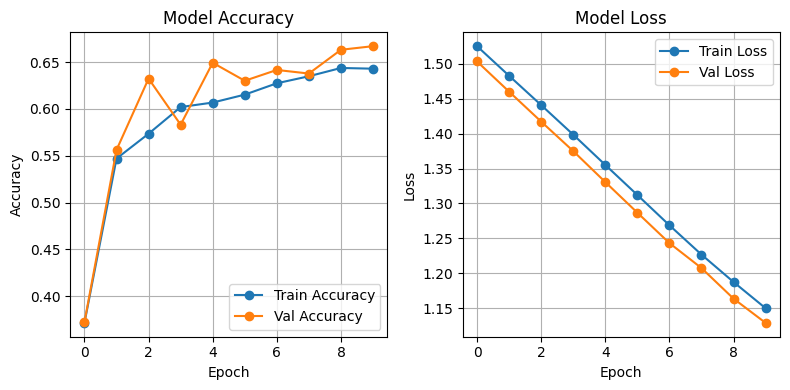

<Figure size 640x480 with 0 Axes>

In [9]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('training_curves_for_ecg_mmodel.png')

In [10]:
def load_user_signal(folder_path, record_name='sample'):
    record = wfdb.rdrecord(f"{folder_path}/{record_name}")
    signal = record.p_signal[:, 0]  # First lead
    fs = record.fs
    return signal[:2*fs], fs  # First 2 seconds

In [11]:
print(train_gen.class_indices)

{'arrhythmia': 0, 'artial_shuffled': 1, 'malignant_shuffled': 2, 'normal': 3, 'st_shuffled': 4}


In [12]:
def predict_heart_condition(model_path, img_path):
    model = load_model(model_path)
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0]
    predicted_class = np.argmax(prediction)
    class_labels = ['arrhythmia','artial','malignant', 'normal', 'st-change']
    return class_labels[predicted_class]

In [13]:
signal, fs = load_user_signal('./user/normal','./16786')  # Assuming user_ecg.dat/.hea exists
generate_scalogram(signal, 'user_scalogram.png')
result = predict_heart_condition('ecg_model_resnet101_epochs-10.h5', 'user_scalogram.png')
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: normal


In [14]:
def complete_pipeline_1(folder_path,record_name,output_path,model_path):
    signal, fs = load_user_signal(folder_path,record_name)
    generate_scalogram(signal,output_path)
    result = predict_heart_condition(model_path,output_path)
    print("Prediction:", result)

In [15]:
def complete_pipeline(folder_path, record_name, true_label):
    signal, fs = load_user_signal(folder_path, record_name)
    generate_scalogram(signal, 'user_scalogram.png')
    predicted_label = predict_heart_condition('ecg_model_resnet101_epochs-10.h5', 'user_scalogram.png')

    # Plot signal with predicted and true label in title
    time = np.linspace(0, 2, len(signal))  # 2 seconds
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, color='black')
    plt.title(f"Predicted: {predicted_label} | True: {true_label}", fontsize=14)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Prediction:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


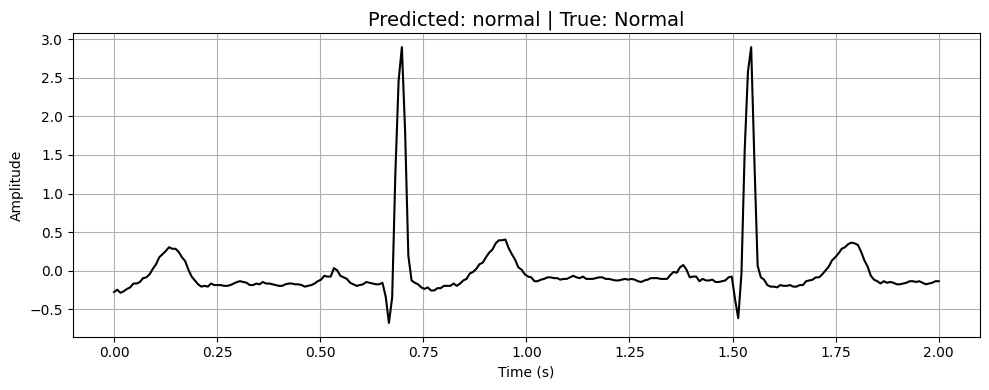

Prediction: normal


In [16]:
complete_pipeline('./user/normal','16786',true_label='Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


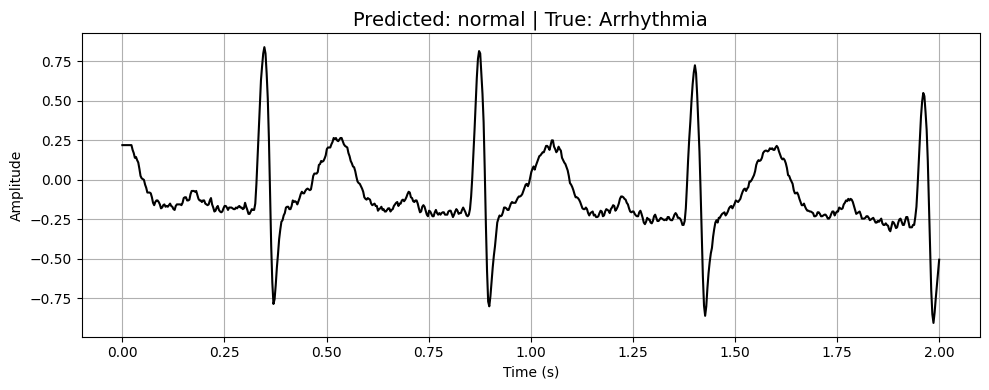

Prediction: normal


In [17]:
complete_pipeline('./user/arrhy','215',true_label='Arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


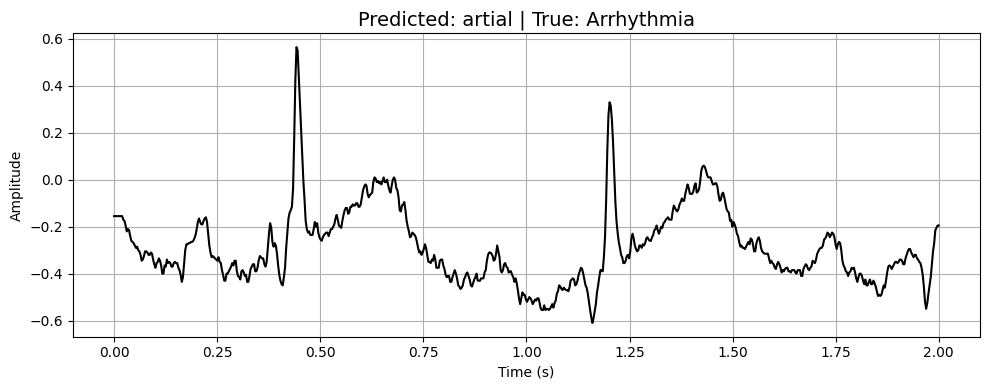

Prediction: artial


In [18]:
complete_pipeline('./user/arrhy','228',true_label='Arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


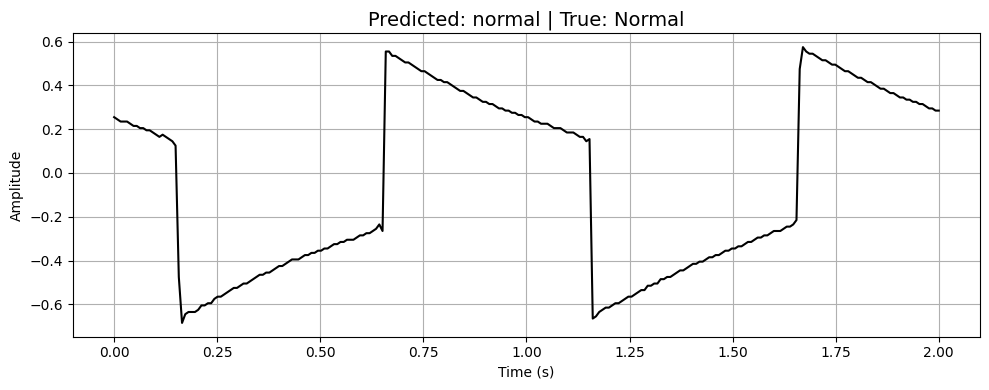

Prediction: normal


In [19]:
complete_pipeline('./user/normal','19140',true_label='Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


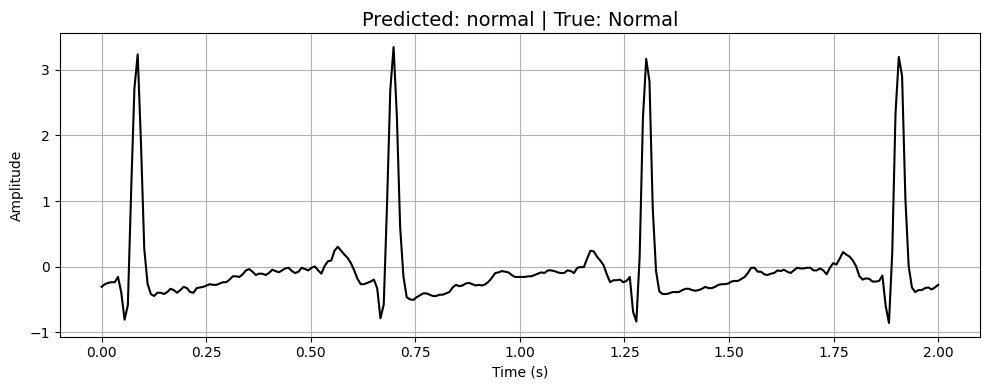

Prediction: normal


In [20]:
complete_pipeline('./user/normal','16273',true_label='Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


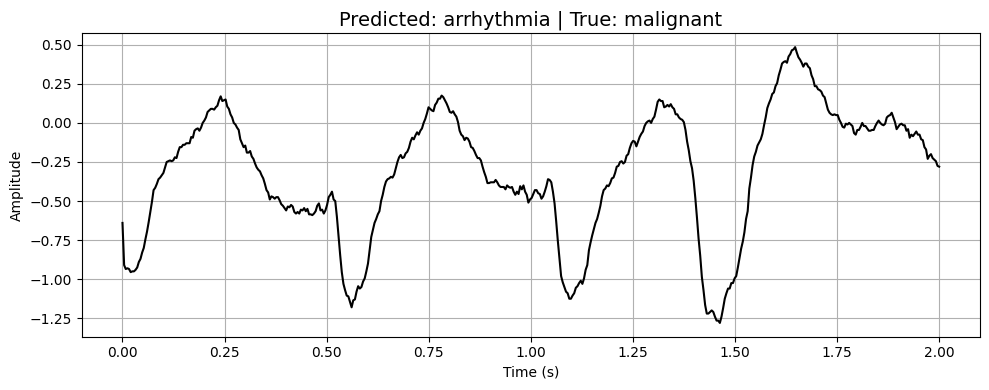

Prediction: arrhythmia


In [21]:
complete_pipeline('./user/malignant/','418',true_label='malignant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


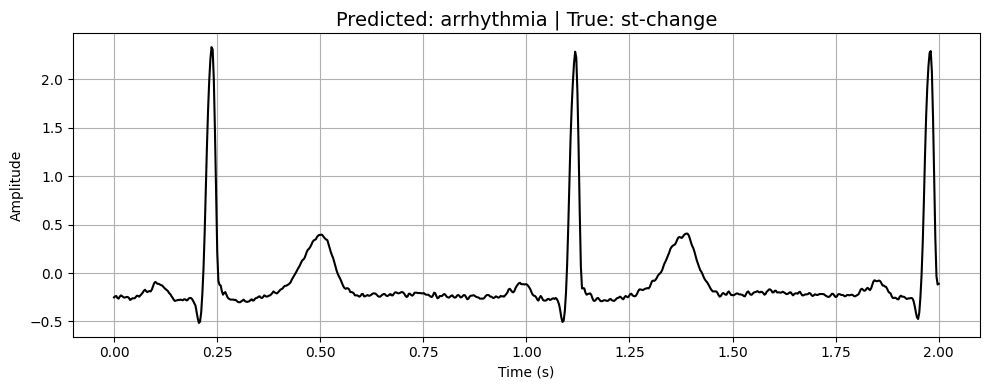

Prediction: arrhythmia


In [22]:
complete_pipeline('./user/st/','313',true_label='st-change')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


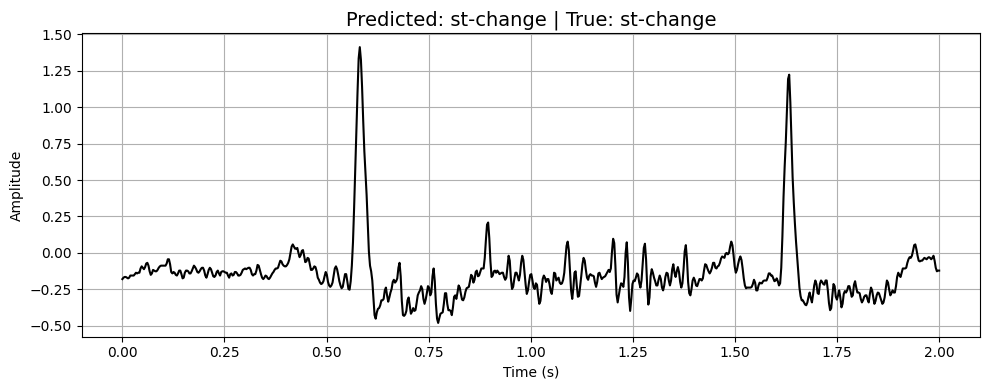

Prediction: st-change


In [23]:
complete_pipeline('./user/st/','314',true_label='st-change')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


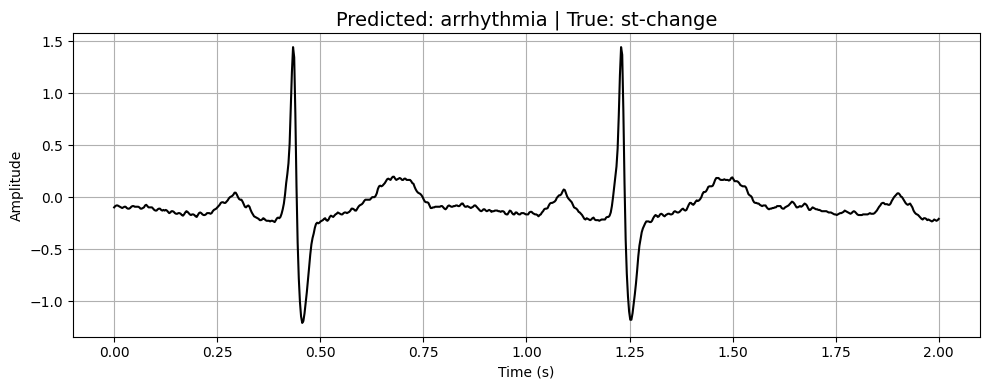

Prediction: arrhythmia


In [24]:
complete_pipeline('./user/st/','321',true_label='st-change')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


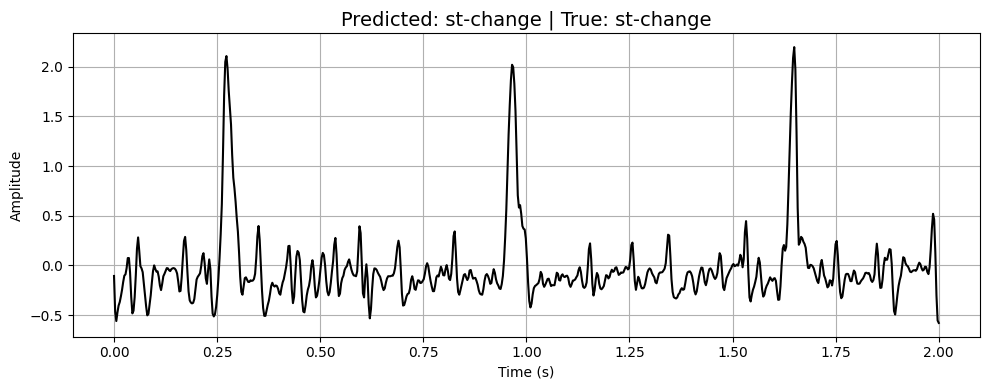

Prediction: st-change


In [25]:
complete_pipeline('./user/st/','322',true_label='st-change')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


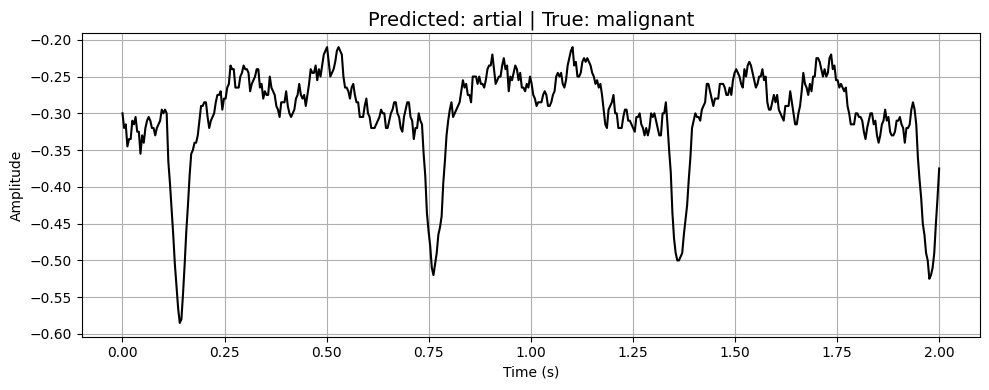

Prediction: artial


In [26]:
complete_pipeline('./user/malignant/','429',true_label='malignant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


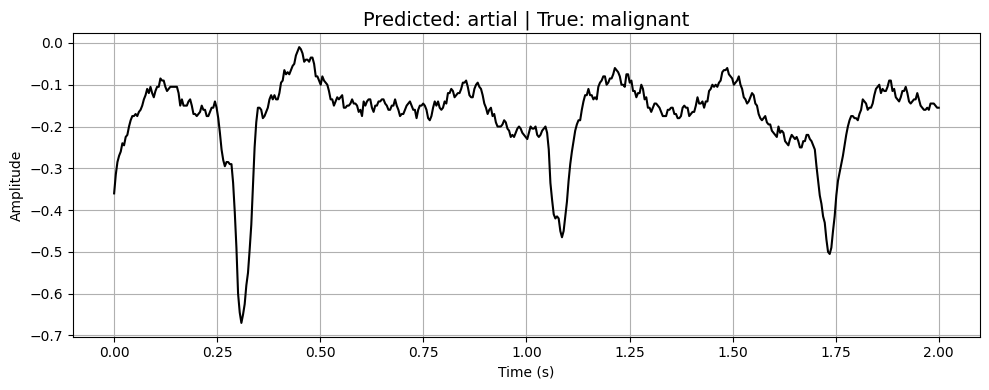

Prediction: artial


In [27]:
complete_pipeline('./user/malignant/','430',true_label='malignant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


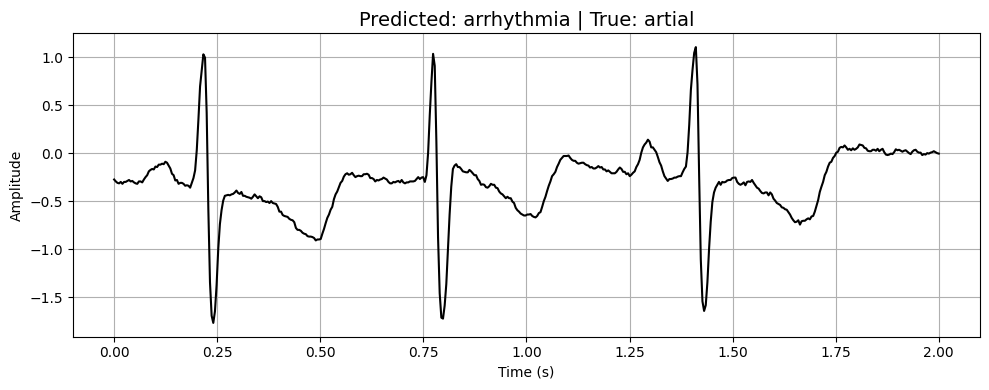

Prediction: arrhythmia


In [28]:
complete_pipeline('./user/artial/','04015',true_label='artial')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


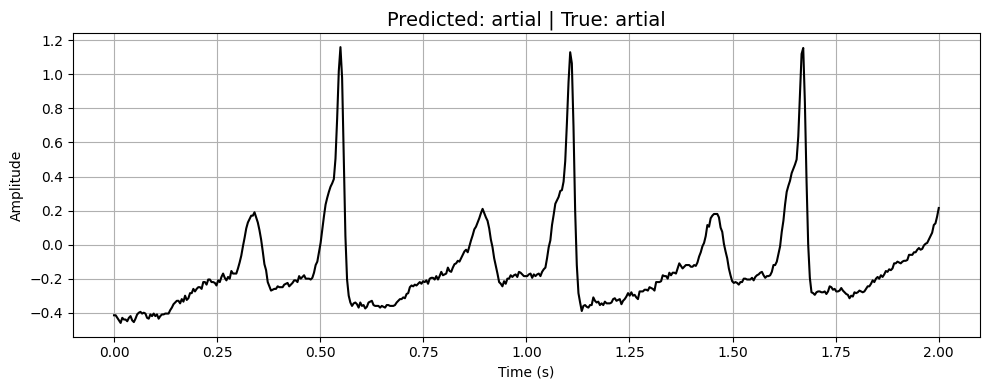

Prediction: artial


In [29]:
complete_pipeline('./user/artial/','04043',true_label='artial')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


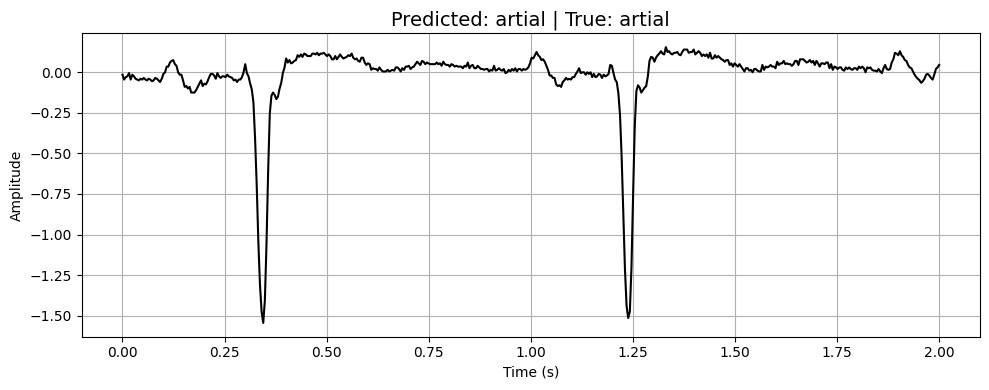

Prediction: artial


In [30]:
complete_pipeline('./user/artial/','04936',true_label='artial')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


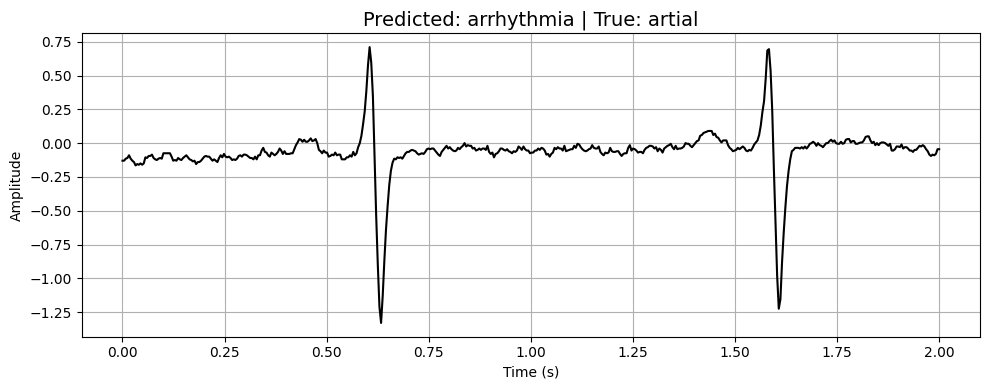

Prediction: arrhythmia


In [31]:
complete_pipeline('./user/artial/','05091',true_label='artial')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


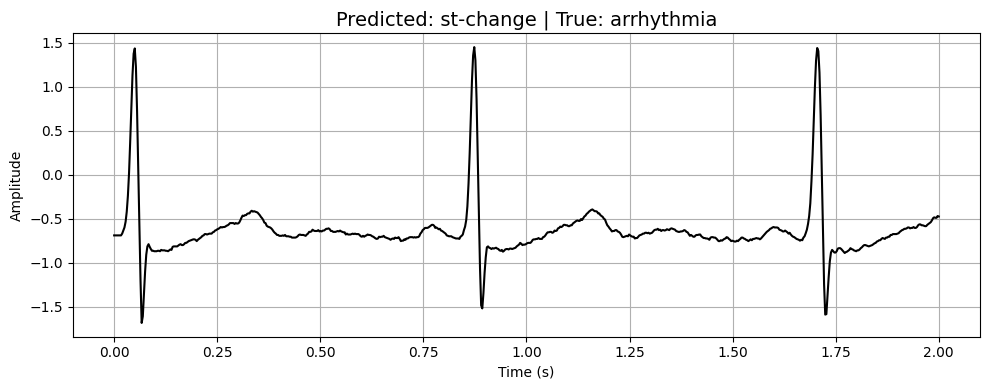

Prediction: st-change


In [32]:
complete_pipeline('./user/arrhy/','220',true_label='arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


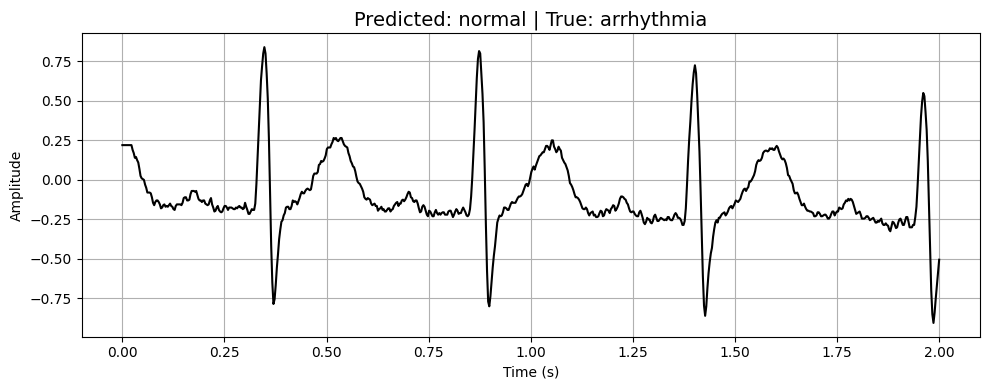

Prediction: normal


In [33]:
complete_pipeline('./user/arrhy/','215',true_label='arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


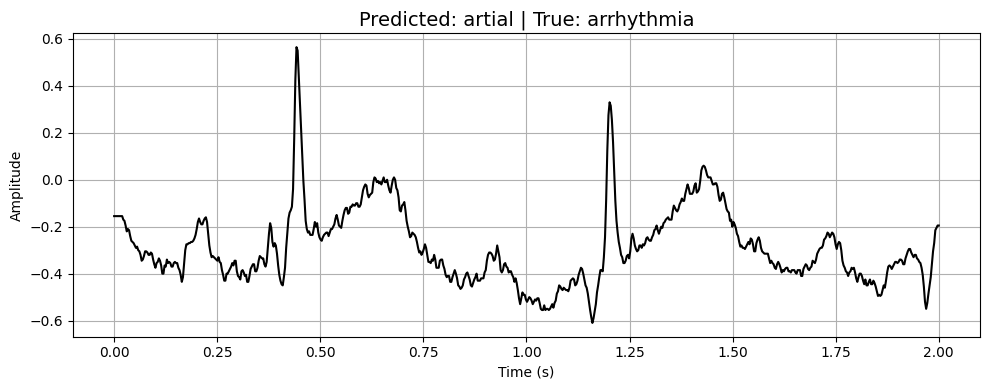

Prediction: artial


In [34]:
complete_pipeline('./user/arrhy/','228',true_label='arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


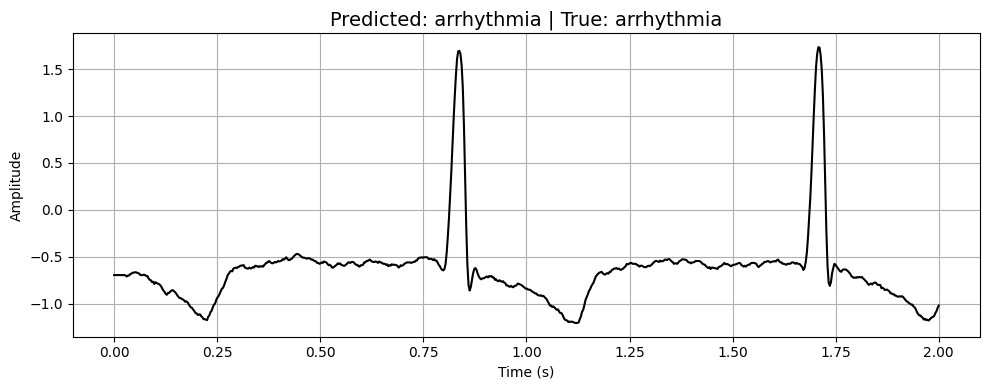

Prediction: arrhythmia


In [35]:
complete_pipeline('./user/arrhy/','219',true_label='arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


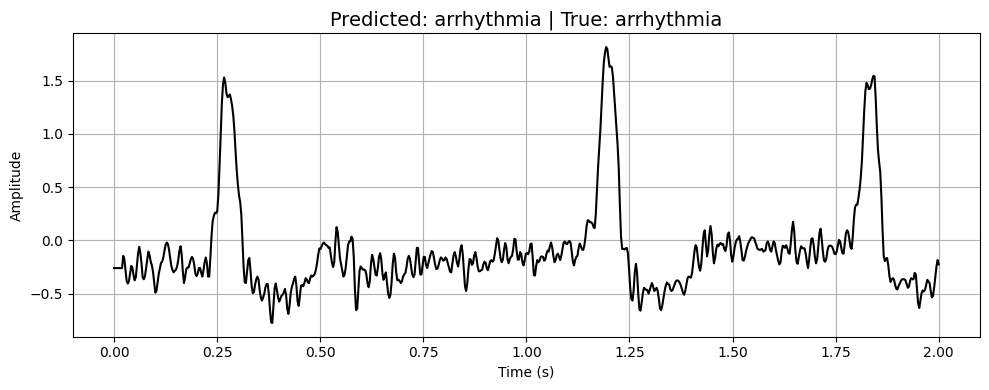

Prediction: arrhythmia


In [36]:
complete_pipeline('./user/arrhy/','203',true_label='arrhythmia')